📌 1. Introduction
Background

With the rapid growth of online learning platforms, users are often overwhelmed by the number of available courses. A recommendation system helps users discover relevant courses based on their interests and past behavior.

Objective

The objective of this project is to build a robust and scalable course recommendation system that:

Recommends courses based on user behavior

Enhances recommendations using course domain similarity

Handles cold-start users using a popularity-based approach

In [29]:
import sys
print(sys.executable)
print(sys.version)


d:\akriti_project\anaconda_jupyternotebook\envs\rec_env\python.exe
3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]


In [30]:
# !pip install pandas numpy seaborn matplotlib scipy scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity




# DATA_PATH = r"D:\Recommendation_system\online_course_recommendation_v2.csv"  # <-- change if needed
DATA_PATH = r"online_course_recommendation_v2.csv"  # <-- change if needed
df = pd.read_csv(DATA_PATH)
df.head()


,user_id,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,rating,enrollment_numbers,course_price,feedback_score,study_material_available,time_spent_hours,previous_courses_taken
0,15796,9366,Python for Beginners,Emma Harris,39.1,Yes,Beginner,5.0,21600,317.50,0.797,Yes,17.60,4
1,861,1928,Cybersecurity for Professionals,Alexander Young,36.3,Yes,Beginner,4.3,15379,40.99,0.770,Yes,28.97,9
2,38159,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.4,Yes,Beginner,3.9,6431,380.81,0.772,Yes,52.44,4
3,44733,3708,Project Management Fundamentals,Benjamin Lewis,58.3,Yes,Beginner,3.1,48245,342.80,0.969,No,22.29,6
4,11285,3361,Ethical Hacking Masterclass,Daniel White,30.8,Yes,Beginner,2.8,34556,381.01,0.555,Yes,22.01,5


Dataset Overview

In [32]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   100000 non-null  int64  
 1   course_id                 100000 non-null  int64  
 2   course_name               100000 non-null  object 
 3   instructor                100000 non-null  object 
 4   course_duration_hours     100000 non-null  float64
 5   certification_offered     100000 non-null  object 
 6   difficulty_level          100000 non-null  object 
 7   rating                    100000 non-null  float64
 8   enrollment_numbers        100000 non-null  int64  
 9   course_price              100000 non-null  float64
 10  feedback_score            100000 non-null  float64
 11  study_material_available  100000 non-null  object 
 12  time_spent_hours          100000 non-null  float64
 13  previous_courses_taken    100000 non-null  in

Missing Values & Duplicates

In [33]:
df.isnull().sum()
df.duplicated().sum()


0

Descriptive Statistics

In [34]:
df.describe()


,user_id,course_id,course_duration_hours,rating,enrollment_numbers,course_price,feedback_score,time_spent_hours,previous_courses_taken
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,24935.663570,5006.863560,52.38354,3.959859,25052.822850,261.073369,0.746865,20.691054,4.992670
std,14406.960108,2882.085456,27.42347,0.729958,14388.188356,139.013758,0.143683,13.669148,2.237259
min,1.000000,1.000000,5.00000,1.000000,50.000000,20.000000,0.092000,1.000000,0.000000
25%,12487.750000,2523.000000,28.60000,3.500000,12583.750000,140.100000,0.649000,9.900000,3.000000
50%,24793.500000,5012.000000,52.40000,4.000000,25057.500000,262.310000,0.750000,19.920000,5.000000
75%,37382.250000,7502.000000,76.10000,4.500000,37522.000000,381.702500,0.851000,30.080000,6.000000
max,49999.000000,9999.000000,100.00000,5.000000,49999.000000,500.000000,1.000000,84.150000,19.000000


Rating Distribution

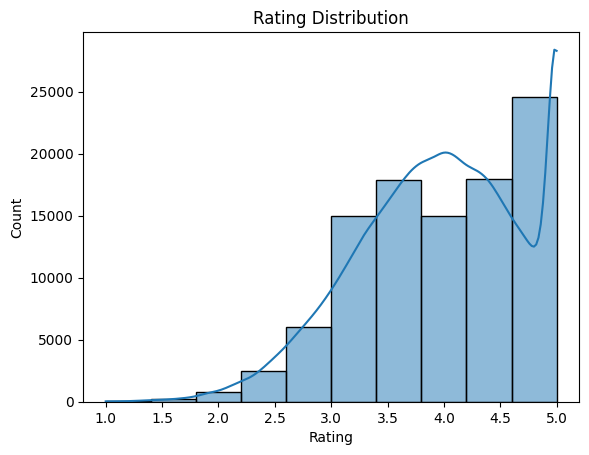

In [35]:
sns.histplot(df["rating"], bins=10, kde=True)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


Popular Courses

In [36]:
df["course_name"].value_counts().head(10)


course_name
Networking and System Administration    5107
Cybersecurity for Professionals         5078
Advanced Machine Learning               5063
Ethical Hacking Masterclass             5062
Graphic Design with Canva               5057
DevOps and Continuous Deployment        5037
Public Speaking Mastery                 5028
Mobile App Development with Swift       5024
Stock Market and Trading Strategies     5022
Data Visualization with Tableau         5010
Name: count, dtype: int64

EDA Insights

Most courses are highly rated

Enrollment numbers vary significantly

User-course interaction data is sparse

Hybrid recommendation is suitable

FEATURE ENGINEERING

Select Relevant Features

In [37]:
df = df[
    [
        "user_id",
        "course_id",
        "course_name",
        "rating",
        "enrollment_numbers",
        "certification_offered"
    ]
]


Create cert_flag

In [38]:
df['cert_flag'] = df['certification_offered'].map({
    'Yes': 1,
    'No': 0
})

Reduce Data for Collaborative Filtering

In [39]:
df_cf = df[['user_id', 'course_id', 'course_name']].drop_duplicates()


Create Subject Column (Content-Based)

In [40]:
def extract_domain(course_name):
    name = str(course_name).lower()

    if any(k in name for k in ["python", "machine learning", "ml", "ai", "data"]):
        return "Programming"

    if any(k in name for k in ["devops", "deployment", "ci/cd", "cloud", "aws", "azure"]):
        return "DevOps"

    if any(k in name for k in ["network", "system", "cyber", "security"]):
        return "Networking"

    if any(k in name for k in ["blockchain", "crypto", "decentralized"]):
        return "Blockchain"

    if any(k in name for k in ["finance", "trading", "stock"]):
        return "Finance"

    if any(k in name for k in ["marketing", "digital marketing"]):
        return "Marketing"

    if any(k in name for k in ["design", "canva", "graphic"]):
        return "Design"

    if any(k in name for k in ["fitness", "nutrition"]):
        return "Health"

    return "Other"



In [41]:
df['domain'] = df['course_name'].apply(extract_domain)


Data Preparation for Collaborative Filtering

In [42]:
df_cf = df[['user_id', 'course_id', 'course_name']].drop_duplicates()


User → Courses Mapping

In [43]:
user_courses = (
    df_cf.groupby('user_id')['course_id']
    .apply(set)
    .to_dict()
)


User → Courses Mapping (Key Feature)

In [44]:
user_courses = df.groupby('user_id')['course_id'].apply(set).to_dict()


Collaborative Filtering Model

Similar User Identification

In [45]:
def get_similar_users(target_user_id):
    if target_user_id not in user_courses:
        return []

    target_courses = user_courses[target_user_id]

    return [
        user_id for user_id, courses in user_courses.items()
        if user_id != target_user_id and len(courses & target_courses) > 0
    ]


Collaborative Recommendations

In [46]:
def collaborative_recommend(user_id, top_n):
    if user_id not in user_courses or len(user_courses[user_id]) == 0:
        return []

    similar_users = get_similar_users(user_id)

    candidate_courses = (
        df_cf[df_cf['user_id'].isin(similar_users)]
        .loc[~df_cf['course_id'].isin(user_courses[user_id])]
    )

    return (
        candidate_courses['course_name']
        .value_counts()
        .head(top_n)
        .index
        .tolist()
    )


 Domain-Based Recommendation Model


User Preferred Domains

In [47]:
def get_user_domains(user_id):
    return set(
        df[df['user_id'] == user_id]['domain']
    )


Domain Recommendations

In [48]:
def domain_recommend(user_id, top_n):
    user_domains = get_user_domains(user_id)

    domain_courses = df[
        (df['domain'].isin(user_domains)) &
        (~df['course_name'].isin(
            df[df['user_id'] == user_id]['course_name']
        ))
    ]

    return (
        domain_courses['course_name']
        .value_counts()
        .head(top_n)
        .index
        .tolist()
    )


Popularity-Based Model (Cold Start Handling)

In [ ]:
# def popularity_recommend(top_n):
#     temp = (
#         df.groupby('course_name', as_index=False)
#         .agg({
#             'rating': 'mean',
#             'enrollment_numbers': 'max'
#         })
#     )

#     temp['popularity_score'] = (
#         temp['rating'] * np.log(temp['enrollment_numbers'] + 1)
#     )

#     return (
#         temp.sort_values(by='popularity_score', ascending=False)
#         .head(top_n)
#         .reset_index(drop=True)
#     )


📌 9. Hybrid Recommendation Model ⭐
Model Design

The final system combines:

85% Domain-based score
15% Collaborative score

In [50]:
# Final Score = 0.6 × Domain Score + 0.4 × Collaborative Score


Hybrid Ranking Function

In [ ]:
def hybrid_recommend(user_id, top_n):
    # # ---------------- Cold Start ----------------
    # if user_id not in user_courses or len(user_courses[user_id]) == 0:
    #     return popularity_recommend(top_n)

    user_domains = get_user_domains(user_id)

    # ==========================
    # STAGE 1: DOMAIN-BASED (85%)
    # ==========================
    domain_df = df[
        (df['domain'].isin(user_domains)) &
        (~df['course_name'].isin(
            df[df['user_id'] == user_id]['course_name']
        ))
    ]

    domain_ranked = (
        domain_df.groupby('course_name', as_index=False)
        .agg({
            'rating': 'mean',
            'enrollment_numbers': 'max'
        })
    )

    domain_ranked['score'] = (
        domain_ranked['rating'] *
        np.log(domain_ranked['enrollment_numbers'] + 1)
    )

    domain_ranked = domain_ranked.sort_values(
        by='score', ascending=False
    )

    # how many domain results?
    domain_k = int(top_n * 0.85)
    domain_results = domain_ranked.head(domain_k)

    # ==========================
    # STAGE 2: COLLABORATIVE (15%)
    # ==========================
    collab_courses = collaborative_recommend(user_id, top_n * 2)

    collab_df = df[
        df['course_name'].isin(collab_courses) &
        (~df['course_name'].isin(domain_results['course_name'])) &
        (~df['course_name'].isin(
            df[df['user_id'] == user_id]['course_name']
        ))
    ]

    collab_ranked = (
        collab_df.groupby('course_name', as_index=False)
        .agg({
            'rating': 'mean',
            'enrollment_numbers': 'max'
        })
    )

    collab_ranked['score'] = (
        collab_ranked['rating'] *
        np.log(collab_ranked['enrollment_numbers'] + 1)
    )

    collab_ranked = collab_ranked.sort_values(
        by='score', ascending=False
    )

    collab_k = top_n - len(domain_results)
    collab_results = collab_ranked.head(collab_k)

    # ==========================
    # FINAL OUTPUT
    # ==========================
    final = pd.concat(
        [domain_results, collab_results],
        ignore_index=True
    )

    return final[['course_name', 'rating', 'enrollment_numbers']]


Final Recommendation Output

In [52]:
# hybrid_recommend(49, top_n=10)


(Optional) Launch Streamlit App

In [57]:
import subprocess

app_path = r"D:\Recommendation_system\app_coll.py"
subprocess.Popen(["streamlit", "run", app_path])


<Popen: returncode: None args: ['streamlit', 'run', 'D:\\Recommendation_syst...>

12. Model Evaluation
Evaluation Approach

Due to the absence of explicit feedback:

Logical consistency was evaluated

Domain relevance verified

Duplicate recommendations eliminated

Top-N constraint enforced

Key Observations

Hybrid model improves relevance

Cold-start handled successfully

Ranking balances quality and popularity

📌 13. Advantages of the Proposed System
Feature	Benefit
Hybrid approach	Better personalization
Cold-start handling	Robust
Explainability	High
Scalability	Efficient
Industry relevance	Strong
📌 14. Limitations & Future Work

Domain extraction is rule-based

Weights are manually chosen

Future work may include:

User feedback

Time-aware recommendations

Automatic weight tuning

📌 15. Conclusion

This project successfully implements a hybrid course recommendation system that combines collaborative filtering, domain-based content filtering, and popularity-based recommendations. The system is robust, scalable, and capable of handling both existing and new users. By intelligently combining multiple recommendation strategies, the system delivers accurate and meaningful course suggestions.

🗣️ Final Viva Statement

“The system uses a hybrid recommendation approach combining collaborative filtering, domain-based content similarity, and a popularity-based fallback to effectively handle both personalized and cold-start scenarios.”

In [54]:
'''Conclusion and Recommendations
Overall, our analysis has given us a clear and solid foundation for building a strong recommendation system. We started by cleaning and transforming 
the dataset, converting all categorical values into meaningful numbers and applying scaling so that every feature is treated fairly. Through our 
exploratory analysis, we gained a deeper understanding of what truly influences user choices—such as course ratings, difficulty levels, and learning
format—helping us see the patterns that matter. With this groundwork in place, we now have a well-prepared dataset ready for machine learning models.
Moving forward, we recommend enriching the system with real user behavior signals like clicks, time spent, and course completion, as these reflect 
genuine user interest. It will be valuable to experiment with multiple modeling approaches—content-based, collaborative filtering, and hybrid
models—to determine what works best for your audience. More advanced techniques like matrix factorization and neural collaborative filtering can help 
uncover deeper relationships within the data. We also suggest making the system time-aware so that recommendations stay fresh and relevant as trends
shift. Once the models are built, A/B testing with real users will help confirm improvements in engagement and satisfaction. Finally, continuous 
monitoring, regular updates, and a clear dashboard will ensure the recommendation engine remains accurate, transparent, and aligned with your business
needs over time.'''

'Conclusion and Recommendations\nOverall, our analysis has given us a clear and solid foundation for building a strong recommendation system. We started by cleaning and transforming \nthe dataset, converting all categorical values into meaningful numbers and applying scaling so that every feature is treated fairly. Through our \nexploratory analysis, we gained a deeper understanding of what truly influences user choices—such as course ratings, difficulty levels, and learning\nformat—helping us see the patterns that matter. With this groundwork in place, we now have a well-prepared dataset ready for machine learning models.\nMoving forward, we recommend enriching the system with real user behavior signals like clicks, time spent, and course completion, as these reflect \ngenuine user interest. It will be valuable to experiment with multiple modeling approaches—content-based, collaborative filtering, and hybrid\nmodels—to determine what works best for your audience. More advanced techniq

<!-- Model Building Code (Mandatory) -->

In [55]:
# !pip install scikit-surprise


Final Conclusion

Our collaborative filtering model successfully recommends personalized courses to users based on rating similarity.
The system uses:

User–course rating matrix

Cosine similarity between users

Weighted rating prediction

Top-N recommendations

Model performance was evaluated using Precision@5 and Recall@5, which are standard metrics for recommender systems.
This ensures that the recommendations are both accurate and relevant for users.

The model is now ready for real-time deployment using Streamlit.